# Fokker-Planck - VarQITE $\chi_0=10^{-2}$

Steps:
- Classical PDE solver (benchmark)
- Initial distribution function
    - fit a target distribution with the correct sigma0
    - get advection parameter to get correct initial function
- VarQITE MVP for digital quantum circuit approach

Ansatz: n=6 (#qubits) and k=6 (#layers)

In [3]:
import warnings
warnings.filterwarnings('ignore')
import PDEsolverQRR
from PDEsolverQRR import *
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import pickle
from numpy import exp, sqrt, pi, log
#from scipy.linalg import solve
#from scipy.linalg import cho_factor, cho_solve
this_files_name = 'VarQITE_chi2_params0_n6k6'

In [4]:
# parameters
nqubits = 6
klayers = nqubits

chi0 = 1e-2
g0 = 1800
sigma0 = 90
tdim = 600 #400
tmax = 20.0
gmlst = np.linspace(400,2200,2**nqubits) #[] energy array
tlst_vqs = np.linspace(0,tmax,tdim)

nparams = klayers*(nqubits-1) + 2 # for symmetric , includes global non-quantum amplitude and advection operator
print("#params=",nparams, ", 2^n=", 2**nqubits)
steps0 = 350 # initial wavefunction optimization steps

#params= 27 , 2^n= 64


In [39]:
# initial target distribution
f0 = np.zeros(2**nqubits)
f0 = exp( -0.5*((gmlst-g0)/(sigma0) )**2 ) # * np.heaviside(1800-gmlst,0) # 1*dx*g0
f0[0] = 0
f0[-1] = 0
f0_target = f0/sqrt(np.sum(np.abs(f0)**2))
#
f0_target_centered = exp( -0.5*((gmlst-np.mean(gmlst))/(sigma0) )**2 )
f0_target_centered = f0_target_centered/sqrt(np.sum(np.abs(f0_target_centered)**2))

In [8]:
dev = qml.device('default.qubit', wires=nqubits)

@qml.qnode(dev) #, interface='jax'
def circuit5(x):
    # first RY rotations
    for i in range(nqubits):
        if i==nqubits-1:
            qml.RY(pi/2, wires=i) # this parameter is fixed
        else:
            qml.RY(x[i], wires=i) # parameters that can be optimized
    # intermediate blocks 
    for k in range(klayers-1):
        for i in range(nqubits-1):
            #qml.CRY(x[ i + (k+1)*(nqubits-1) ], wires=[ (i)%(nqubits-1) , (i+1)%(nqubits-1) ] )
            qml.CNOT( wires=[ (i)%(nqubits-1) , (i+1)%(nqubits-1) ] )
        for i in range(nqubits-1):
            qml.RY(x[ i + (k+1)*(nqubits-1) ], wires=i) # parameters that can be optimized
    # final symmetry enforcing block
    for i in range(nqubits-1):
        qml.CNOT(wires=[nqubits-1,nqubits-i-2])
    return np.real( qml.state() )

def getPsi_t0(x):
    return circuit5(x[:-2])

In [41]:
# initial random parameters
params_new0 = np.array(np.random.rand(nparams),requires_grad=True) * (2*pi)

# cost function
def cost_target_f0(x):
    return np.sum( np.abs( np.real(getPsi_t0(x))-f0_target_centered)**2 )

# initialise the optimizer
opt0 = qml.AdagradOptimizer(stepsize=0.25) #qml.GradientDescentOptimizer(stepsize=0.6)

cost0lst = np.zeros(steps0)
# fit first psi(t=0)
for i in trange(steps0):
    params_new0[-1] = 1.0
    params_new0[-2] = 0.0
    cost0lst[i] = cost_target_f0(params_new0)
    params_new0 = opt0.step(cost_target_f0, params_new0)
print("final cost", cost0lst[-1])
params_new0[:-2] = params_new0[:-2] % (2*pi)

100%|█████████████████████████████████████████| 350/350 [00:08<00:00, 39.29it/s]

final cost 0.003121868021868403


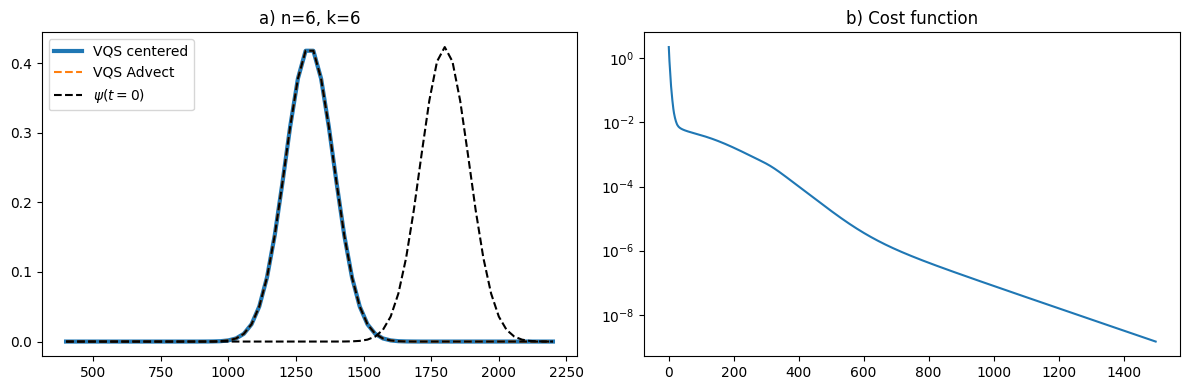

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

# centered
params_new0[-2] = 0
yth = np.real( getPsi_t0(params_new0) ); yth /= np.sign(np.trapz(yth))
axes[0].plot( gmlst, yth , label='VQS centered', linewidth=3 )
# correct for initial average energy
params_new0[-2] = (g0-np.mean(gmlst))/(np.max(gmlst)-np.min(gmlst))
yth = np.real( getPsi_t0(params_new0) ); yth /= np.sign(np.trapz(yth))
axes[0].plot( gmlst, yth, '--', label='VQS Advect' )
axes[0].plot( gmlst, f0_target , 'k--', label=r'$\psi (t=0)$')
axes[0].plot( gmlst, f0_target_centered , 'k--')
axes[0].legend()
axes[0].set_title( 'a) n={}, k={}'.format(nqubits, klayers))
axes[1].set_title( 'b) Cost function' )

axes[1].plot(cost0lst)
axes[1].set_yscale('log')
plt.tight_layout()
#plt.savefig('VQSn5k4_f0.pdf',transparent=True)
plt.show()

In [21]:
# save results
outfile = open(this_files_name,'wb')
pickle.dump([nqubits, klayers, chi0, nparams, steps0, f0_target, f0_target_centered, params_new0, g0, sigma0, cost0lst, gmlst],outfile)
outfile.close()

In [6]:
# load results
infile = open(this_files_name,'rb')
nqubits, klayers, chi0, nparams, steps0, f0_target, f0_target_centered, params_new0, g0, sigma0, cost0lst, gmlst = pickle.load(infile)